This is a Keras implementation of [infoGAN](https://arxiv.org/abs/1606.03657). InfoGAN is designed to learn a disentangled representation of latent space underlying the images being generated, by maximising the mutual information between (a subset of) the input vector and the generated image.


First we'll import all the tools we need and set some initial parameters

In [1]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.initializers import RandomNormal
import keras.backend as K
import time
import keras


# Just in case we're re-running, clear the Keras session data.
K.clear_session()

# Shall we use BatchNormalization layers?
useBN = True
# Shall we use bias?
useBias = True

# Logging directory and label
LOG_DIR = './log'
logSub = "mnistDCGAN"


Using TensorFlow backend.


This is an optional code block for creating an ngrok tunnel to a tensorboard instance. Useful for running on cloud services 

In [2]:
if not os.path.isfile('./ngrok'):
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip  

get_ipython().system_raw(
    'tensorboard --logdir ' + LOG_DIR + ' --host 0.0.0.0 --port 6006 &'
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2018-09-03 07:45:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.44.53.64, 52.23.126.223, 52.5.182.176, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.44.53.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  19.5MB/s    in 0.3s    

2018-09-03 07:45:54 (19.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://e68bd7de.ngrok.io


This code block imports manual logging functionality and defines a couple of extra functions required for GANs in Keras, since we need to use train_on_batch rather than fit. train_on_batch does not log automatically to tensorboard, hence we'll perform the logging manually.

In [3]:
if os.path.isfile('tensorboard_logging.py'): os.remove('tensorboard_logging.py')
!wget https://gist.githubusercontent.com/tjh48/bf56684801d641544e49a5e66bf15fba/raw/9c6e04cca49288ab0920d9a3aeb3283da13d1a39/tensorboard_logging.py
import tensorboard_logging as tbl  

subdir = LOG_DIR + "/" + logSub + '_' + str(int(np.round(time.time())))
logger = tbl.Logger(subdir)

--2018-09-03 07:46:00--  https://gist.githubusercontent.com/tjh48/bf56684801d641544e49a5e66bf15fba/raw/9c6e04cca49288ab0920d9a3aeb3283da13d1a39/tensorboard_logging.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783 (3.7K) [text/plain]
Saving to: ‘tensorboard_logging.py’

tensorboard_logging 100%[===================>]   3.69K  --.-KB/s    in 0s      

2018-09-03 07:46:00 (55.4 MB/s) - ‘tensorboard_logging.py’ saved [3783/3783]



Another optional block to link the google colab instance that I ran this on to my google drive, so that I can export the models to somewhere with permanant storage rather than having them disappear when the virtual machine expires.

In [4]:
if not os.path.isdir('drive'):
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

Next we'll download the MNIST data set. This is actually interesting for infoGAN, because we have both categorical (e.g., which number is drawn) and continuous (e.g., how thick the pen strokes are) variation.

We'll also define a function for plotting MNIST-type images so that we can see the output of the generator.

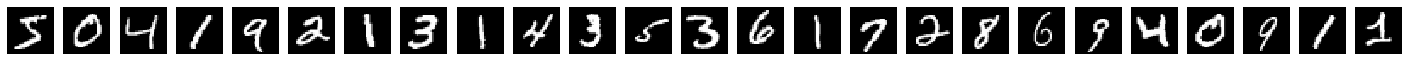

In [11]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

# just for fun, you can drop in the fashion_mnist dataset here instead of standard mnist
#from keras.datasets import fashion_mnist
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 127.5 - 1
x_test = x_test.astype('float32') / 127.5 - 1

x_train = x_train[:, :, :, np.newaxis]

def plotImages(images, ncols = 25, nrows = 1, filename = ""):
  plt.figure(figsize = (1*ncols, 0.9 * nrows))
  for rr in range(nrows):
    for ii in range(ncols):
      ax = plt.subplot(nrows, ncols, rr * ncols + ii + 1)
      x = images[rr * ncols + ii] * 255
      if x.shape[2] == 1:
        x = x.reshape(x.shape[0:2])
        plt.gray()
      plt.imshow(x)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  if filename == "":
    plt.show()
  else: 
    plt.savefig(filename)

  
plotImages(x_train)

In [0]:
def genfun(inputs, initialFeatures = 256, outputDim = 32, outputFeatures = 3, minimumDim = 5):
  # inputs are now a list of categorical, continuous and random noise tensors
  inputLayer = Concatenate()(inputs)
  
  # Here we find the number of times the output dimension is divisible by 2
  # while still keeping the initial dimension of the data above some threshold.
  # Letting the threshold go too low results in model collapse; ad hoc experimentation suggests that
  # an initial dimension >= 5 is ok.
  for loop in range(int(np.log2(outputDim)) + 1):
    if(outputDim % np.power(2, loop) != 0 or outputDim / np.power(2, loop) < minimumDim):
      break
  
  # Given the number of times the output dimension is divisible by 2,
  # we can determine the initial dimension of the dense layer from a random vector.
  initialDim = outputDim // np.power(2, loop - 1)
  if initialDim == outputDim:
    raise ValueError("The outputDim is not divisible by 2 - there's no clean way to upsample.")
  
  x = Dense(initialDim*initialDim*initialFeatures, kernel_initializer='glorot_normal', use_bias = useBias)(inputLayer)
  x = LeakyReLU(0.2)(x)
  if useBN: x = BatchNormalization()(x)
  x = Reshape((initialDim, initialDim, initialFeatures))(x)
  
  # Now we can repeatedly upsample doubling the dimension each time 
  # and convolute, halving the number of features
  # until we arrive at (half the) right output dimension
  for ii in range(loop - 1):
    x = UpSampling2D(size=(2, 2), data_format='channels_last')(x)
    if ii < loop - 2:
      x = Conv2D(initialFeatures // np.power(2, ii + 1), kernel_size = 5, padding ='same', use_bias = useBias, strides = 1)(x)
      x = LeakyReLU(0.2)(x)
      if useBN: x = BatchNormalization()(x)
  # now reduce the features to one (for MNIST) - for colour images we may need three or more channels in output
  x = Conv2D(outputFeatures, kernel_size = 5, padding ='same', use_bias = useBias, strides = 1)(x)
  x = Activation('tanh')(x)
  return x

Here's a function to define the generator layer. In DCGAN, we upsample from a random vector to an image, with a convolutional layer at each upsampling. Each upsampling with a 2x2 shape doubles the size of the image, so we can start with with a low-dimensional image with a large number of features and upsample until we get to the right size. 

Here, instead of upsampling from a purely random vector, we upsample from a vector concatenated from categorical random variables, continuous random variables, and an additional noise vector.

Starting with a too-low dimensional image gives model failure, particularly if you don't use batch normalisation. Ad hoc experimentation suggests that an initial dimension > 5 is required to avoid this scenario.


And here's a function to define a discriminator layer. In the original DCGAN paper, this is envisaged as an almost direct mirror image of the generator. It need not be - we could have fewer layers (to make the discriminator less efficient) as long as we end with a dense layer mapping to a single output.

Since we'll need an auxillary model that takes the last-but-one output of the discriminator and gives an output allowing us to calculate (a surrogate for) mutual information between the input and the output, the function returns both this layer and the discriminant.

In [0]:
def disfun(inputImage, initialFeatures= 64, numLayers = 2):
  x = inputImage
  for ii in range(numLayers):
    x = Conv2D(initialFeatures * np.power(2, ii), kernel_size = 5, padding='same', strides=(2,2), use_bias = useBias)(x)
    x = LeakyReLU(0.2)(x)
    if useBN: x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
  x = Flatten()(x)
  discriminant = Dense(1, activation = 'sigmoid', use_bias = useBias, name = "discriminant")(x)
  return discriminant, x

Here we can build the models. We need a discriminator model that can be trained on true/fake images, a generator model that will be used to create fake images, and a combined model that will link the generator to the discriminator to produce the loss on the generator. 

We also need an auxillary model that extends the discriminator layers and finds (a surrogate for) the mutual information between the input parameters and the generated image. We'll be training this as part of the generator (other implementations might train it as part of the discriminator, or separately from both).

In the original paper, the gaussian loss function is used to estimate the mutual information for the continuous variables. If we assume that the standard deviation is constant, this is equivalent to mean-squared-error (mse) loss. Categorical cross-entropy is used to estimate the mutual information for the categorical variables.

Since the loss on the generator is measured by assuming the fake images are real, we need to freeze (set untrainable) the discriminator model so as not to disrupt the training of the discriminator by feeding it false information. We also need to freeze the layers in the discriminator which feed into the auxillary model, which is why we have this slightly cumbersome two-step process to construct the auxillary model (first constructing auxD, which is the non-trainable model producing a vector of auxillary output from the discriminator, then auxQ, which produces the estimates of the information carrying variables from that vector.)

I'm wrapping the whole thing up in a function so that we can easily generate fresh models for use with a tweaked training regime.

In [0]:
optimizer = Adam(0.0002, 0.5)


def auxillary(convDisc):
  def lstdmax(x):
    return K.maximum(x, -16)
  
  Q = Dense(128)(convDisc)
  Q = LeakyReLU(0.2)(Q)
  Q = BatchNormalization()(Q)
  Q = Dense(32)(Q)
  Q = LeakyReLU(0.2)(Q)
  Q = BatchNormalization()(Q)
  catQ = Dense(cat_dim, activation='softmax', name="catQ")(Q)
  meanQ = Dense(cont_dim, name = "meanQ")(Q)
  #meanQ = Reshape((cont_dim, 1))(Dense(cont_dim, name = "meanQ")(Q))
  #lstdQ = Reshape((cont_dim, 1))(Dense(cont_dim, name = "lstdQ")(Q))
  #lstdQ = Lambda(lstdmax)(lstdQ)
  #cQ = Concatenate(name = "cQ")([meanQ, lstdQ])
  return [catQ, meanQ]  
  
def dcganModels():
  
  cat_input = Input(shape=(cat_dim,), name="cat_input")
  cont_input = Input(shape=(cont_dim,), name="cont_input")
  noise_input = Input(shape=(noise_dim,), name="noise_input")
  gen_inputs = [cat_input, cont_input, noise_input]
  
  generator = Model(gen_inputs, genfun(gen_inputs, initialFeatures = 128, outputDim = x_train.shape[2], outputFeatures = x_train.shape[3]))
  generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  
  inputImage = Input(shape=x_train.shape[1:4])
  discriminant, auxin = disfun(inputImage)
  discriminator = Model(inputImage, discriminant)
  discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  discriminator.trainable = False
  
  auxD = Model(inputImage, auxin)
  auxD.compile(loss = 'binary_crossentropy', optimizer = optimizer)
  auxD.trainable = False
  
  generated = generator(gen_inputs) 
  dcganOutput = discriminator(generated)
  auxillaryOutput = auxillary(auxD(generated))
  auxQ = Model(inputs = gen_inputs, outputs = auxillaryOutput)
  auxQ.compile(loss = loss_functions[1:], loss_weights = loss_weights[1:], optimizer = optimizer)
  
  gan = Model(inputs = gen_inputs, outputs = [dcganOutput] + auxillaryOutput)
  gan.compile(loss = loss_functions, loss_weights = loss_weights, optimizer = optimizer)
  discriminator.trainable = True
  
  return gan, discriminator, generator, auxQ

Next we'll create a function that creates the data for each training batch. The random vector fed into the generator is constructed by combining a one-hot vector for the categorical random variables, a normally distributed vector for the continuous random variables, and a noise vector.

In [0]:
def randomBatch(batch_size):
  def sample_cat(batch_size, cat_dim):
      y = np.zeros((batch_size, cat_dim), dtype="float32")
      random_y = np.random.randint(0, cat_dim, size=batch_size)
      y[np.arange(batch_size), random_y] = 1
      return y

  X_cont = []
  X_noise = []
  for i in range(batch_size):
    randomNoise = np.random.normal(0,1,cont_dim)
    X_cont.append(randomNoise)
    randomNoise = np.random.normal(0,1,noise_dim)
    X_noise.append(randomNoise)

  X_cat = sample_cat(batch_size, cat_dim)
  X_cont = np.array(X_cont)
  X_noise = np.array(X_noise)
  return X_cat, X_cont, X_noise

def makeBatch(x_train, batch_size = 128, noisyEpochs = 0.0):
  noise_factor = 0
  if noisyEpochs > 0:
    noise_factor = np.clip(1 - i/noisyEpochs, 0, 1)
  trueImages = x_train[np.random.randint(0, x_train.shape[0], batch_size),]
  trueImages = trueImages + np.random.normal(loc=0.0, scale=noise_factor, size=trueImages.shape)
  trueImages = np.clip(trueImages, -1, 1)
  X_cat, X_cont, X_noise = randomBatch(batch_size)
  #genin = [X_cat, X_cont[:,0], X_noise]
  genin = [X_cat, X_cont, X_noise]
  generatedImages = generator.predict(genin)
  generatedImages = generatedImages + np.random.normal(loc=0.0, scale=noise_factor, size=generatedImages.shape)
  generatedImages = np.clip(generatedImages, -1, 1)
  return genin, X_cat, X_cont, trueImages, generatedImages

Now we can train the models. We first generate the fake images, then train the discriminator on these and an equal sized random batch of the true images. Then we train the generator. Every fifty epochs, we'll take a look at a sample of the current output.

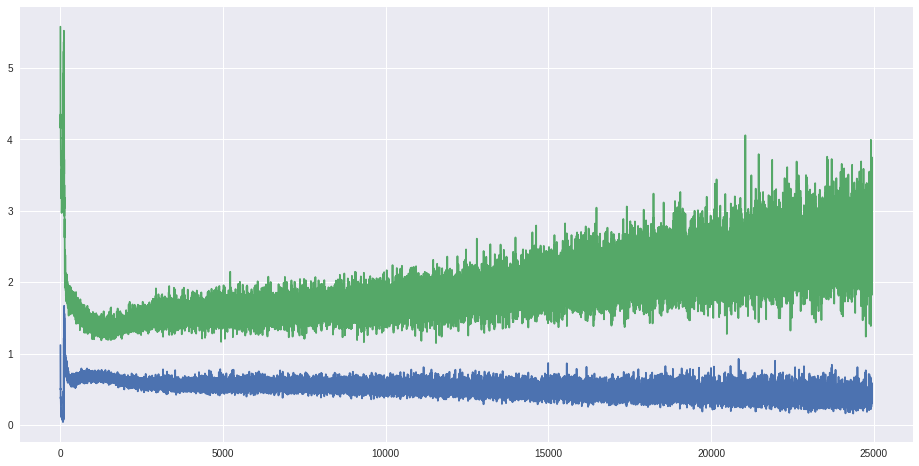

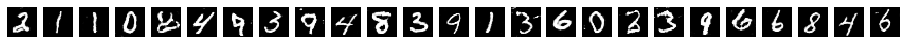

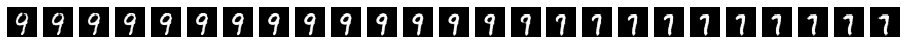

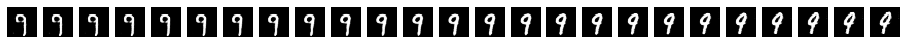

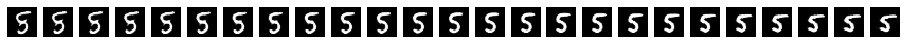

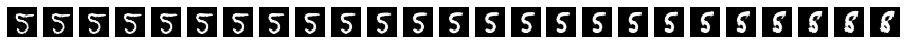

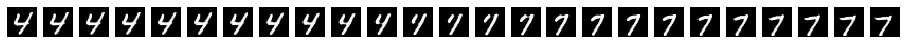

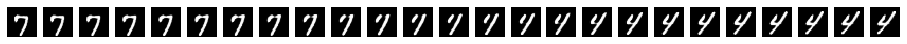

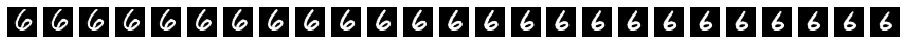

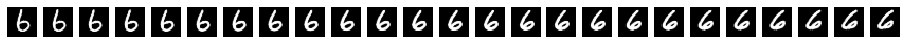

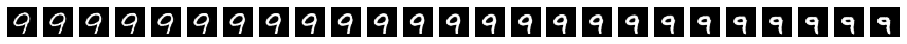

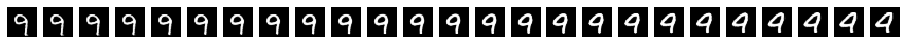

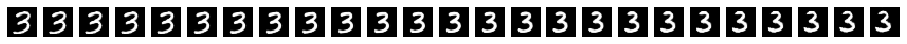

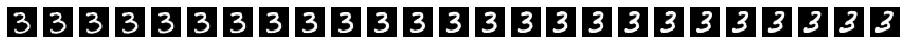

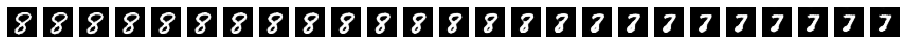

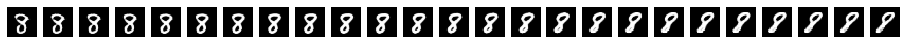

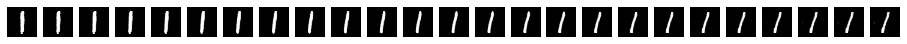

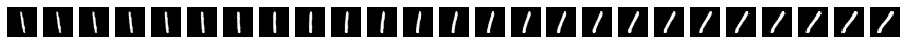

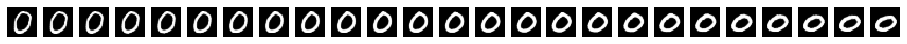

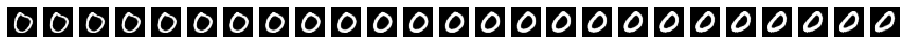

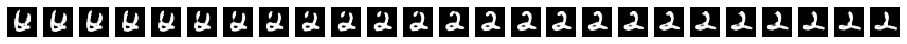

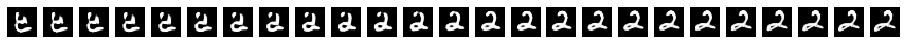

In [10]:
nbEpoch = 25000
loss_functions = ['binary_crossentropy', 'categorical_crossentropy', 'mse']
loss_weights = [1, 1, 0.5]

cat_dim = 10
cont_dim = 2
noise_dim = 32

dLoss = []
gLoss = []

from IPython.display import clear_output, Image

gan, discriminator, generator, auxQ = dcganModels()
batch_size = 32

for epoch in range(nbEpoch):
  genin, X_cat, X_cont, trueImages, generatedImages = makeBatch(x_train)
  discriminatorLoss = 0.5 * (discriminator.train_on_batch(trueImages, np.ones(trueImages.shape[0])) + discriminator.train_on_batch(generatedImages, np.zeros(generatedImages.shape[0])))
  dcganLabels = np.ones(generatedImages.shape[0]).astype(int)			
  discriminator.trainable = False
  dcganLoss = gan.train_on_batch(genin, [dcganLabels, X_cat, X_cont])[0]
  discriminator.trainable = True
  dLoss.append(discriminatorLoss)
  gLoss.append(dcganLoss)
  
  if (epoch % 50 == 0) or (epoch == 0):
    print('after epoch: ', epoch)
    print ('dcgan Loss: ', dcganLoss, '\t discriminator loss', discriminatorLoss)
    if os.path.isdir('drive'):
      gan.save("drive/dcgan.h5")
      auxQ.save("drive/auxQ.h5")
      discriminator.save("drive/discriminator.h5")
      generator.save("drive/generator.h5")
    clear_output(wait=True)
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(16, 8)
    ax1.plot(range(len(dLoss)), dLoss, label="loss generator")
    ax1.plot(range(len(gLoss)), gLoss, label="loss disc-true")
    plt.show()
    plotImages(generatedImages)
    x = np.transpose(np.stack([np.array(range(-12,13)) / 6.0, np.zeros((25,))]))
    y = np.transpose(np.stack([np.zeros((25,)), np.array(range(-12,13)) / 6.0]))
    for ii in range(10):
      cat = np.transpose(np.reshape(np.repeat(keras.utils.to_categorical(range(10))[ii,:], 25), (-1, 25)))
      genin = [cat, x, np.zeros((batch_size, noise_dim))]
      plotImages(generator.predict(genin), 25)
      genin = [cat, y, np.zeros((batch_size, noise_dim))]
      plotImages(generator.predict(genin), 25)

Let's examine the latent variables.

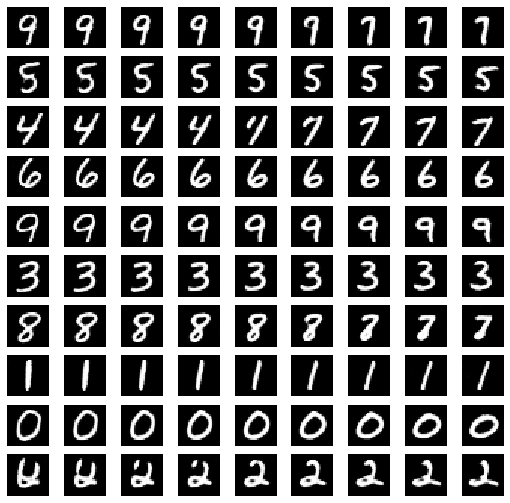

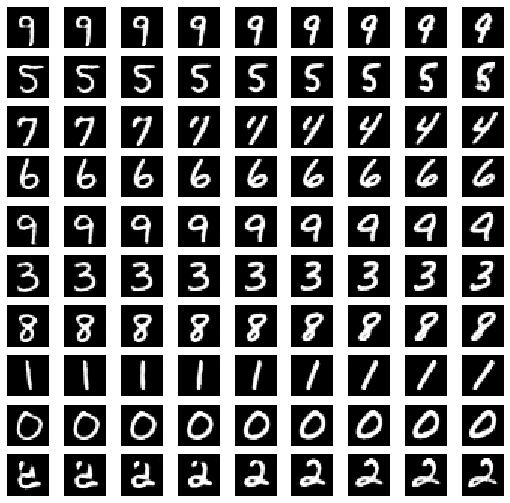

In [18]:
x = np.transpose(np.stack([np.array(range(-4,5)) / 2.5, np.zeros((9,))]))
y = np.transpose(np.stack([np.zeros((9,)), np.array(range(-4,5)) / 2.5]))
latent1 = list()
for ii in range(10):
  cat = np.transpose(np.reshape(np.repeat(keras.utils.to_categorical(range(10))[ii,:], 9), (-1, 9)))
  genin = [cat, x, np.zeros((batch_size, noise_dim))]
  latent1.append(generator.predict(genin))
plotImages(np.concatenate(latent1), 9, 10)
  
latent2 = list()
for ii in range(10):
  cat = np.transpose(np.reshape(np.repeat(keras.utils.to_categorical(range(10))[ii,:], 9), (-1, 9)))
  genin = [cat, y, np.zeros((batch_size, noise_dim))]
  latent2.append(generator.predict(genin))
plotImages(np.concatenate(latent2), 9, 10)  